Step 22: PSG features are aggregated (mean), and logistic regression is trained by aggregated data. Model's classification report, confussion matrix, coefficients, K-folds cross-validation and best features are evaluated. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter as counter
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

%matplotlib inline
warnings.filterwarnings('ignore', category=UserWarning, append=True)

In [3]:
sns.set()
no_subject = 27 # number of subjects
no_channel = 8 # number of channels
no_columns = 198

file_path = './PSG_features/' # features files path
data = pd.read_csv('PSG_features_8chn.csv') # features files names
file_name = data['fname']
psg_data = pd.read_csv('PSG_dataset.csv')
y = psg_data['label']
residual_heartrate_feature = pd.read_csv('residual_heartRate_features.csv') # taking the residual and heart rate

In [4]:
nfile = 0 # counter for the PSG file selecting
file_sel = 0 # counter for assigning the shape of an array
flag_col = -1 # counter of selection of feature file for artifact removing (flag)
X_agg = np.empty((0, no_columns))

for nsub in range(no_subject):
    sub_len = pd.read_csv(file_path+file_name[file_sel]).shape
    data_con = np.empty((sub_len[0],0))
    
    mean_array = np.empty((0))
    column = np.empty((0))
    file_sel += no_channel
    flag_col += no_channel
    
    for nchn in range(no_channel):
        df_feature = pd.read_csv(file_path+file_name[nfile])
        
        if 'alpha_mean' in df_feature.columns:
            df_feat = df_feature.drop(df_feature[['flag', 'alpha_mean', 'theta_mean', 'delta_mean', 'label']], axis=1) # removing columns from EEG channels
            column = np.append(column, df_feat.columns)
            
        else:
            df_feat = df_feature.drop(df_feature[['flag', 'label', 'mean']], axis=1) # removing columns from other PSG channels
            column = np.append(column, df_feat.columns)
            
        data_con = np.concatenate((data_con, df_feat), axis=1)
        nfile += 1
        
    df = pd.DataFrame(data = data_con, columns=column)
    df['flag'] = pd.read_csv(file_path+file_name[flag_col])['flag']
    df_feat = df[df['flag'] == 0]
    df_feat = df_feat.drop(['flag'], axis=1)
    # aggrepating the features
    for i in range(df_feat.shape[1]):
        mean_array = np.append(mean_array, [np.mean(df_feat.iloc[:,i])])
    X_agg = np.append(X_agg, [mean_array], axis=0)
    
print('shape of features after aggregate: {}' .format(X_agg.shape))

shape of features after aggregate: (27, 198)


0.5167603730003287

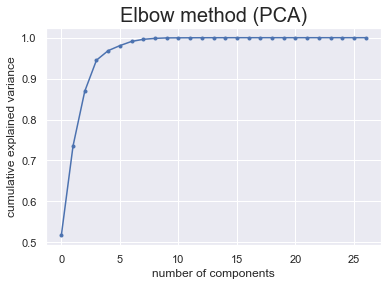

In [5]:
X_merged = np.concatenate((X_agg, residual_heartrate_feature), axis=1)
X_pca = PCA()
X_pca.fit_transform(X_agg)
plt.plot(np.cumsum(X_pca.explained_variance_ratio_), '.-')
plt.title('Elbow method (PCA)', fontsize=20)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
np.max(X_pca.explained_variance_ratio_)

shape of features after applying PCA: (27, 3)


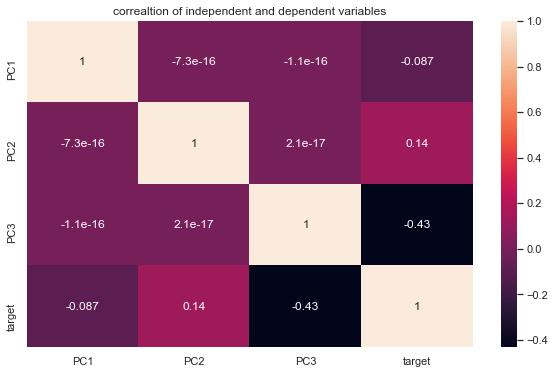

In [6]:
X_scalar = StandardScaler().fit_transform(X_agg)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scalar)
print('shape of features after applying PCA: {}' .format(np.shape(X_pca)))
X = StandardScaler().fit_transform(X_pca)

df_p = pd.DataFrame(data=X, columns=['PC1', 'PC2', 'PC3'])#, 'PC4', 'PC5', 'PC6', 'PC7'])
df_p['target'] = y
plt.figure(figsize=(10,6))
plt.title('correaltion of independent and dependent variables')
sns.heatmap(df_p.corr(), annot=True)
plt.show()

Text(0.5, 1.0, 'scatter plot of 27 subjects')

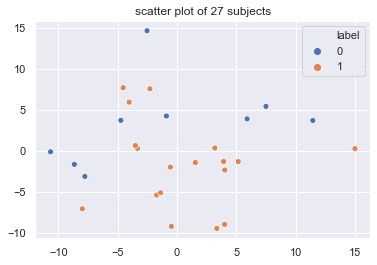

In [7]:
sns.scatterplot(X_pca[:,1], X_pca[:,2], hue=y)
plt.title('scatter plot of 27 subjects')

Text(0.5, 1.0, 'scatter plot of 32 subjects')

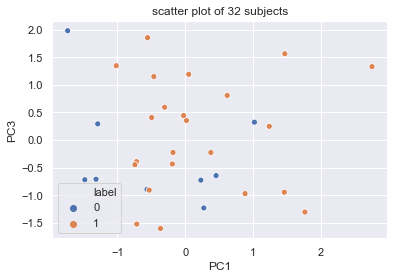

In [8]:
X_l = pd.read_csv('large_dataset_predictors/PSG8_3PC.csv')
y_l = pd.read_csv('large_dataset_predictors/PSG8_3_Clustering.csv')['label']
sns.scatterplot(X_l.iloc[:,0], X_l.iloc[:,2], hue=y_l)
plt.title('scatter plot of 32 subjects')

In [9]:
# merging two datasets
X_merg = np.empty((0, 5))
y_merg = np.empty((0))

X_merg = np.concatenate((X, X_l), axis=0)
y_merg = np.concatenate((y, y_l))

X_merg = StandardScaler().fit_transform(X_merg)

print('shape of merged data {} and their target labels {}' .format(X_merg.shape, y_merg.shape))

shape of merged data (59, 3) and their target labels (59,)


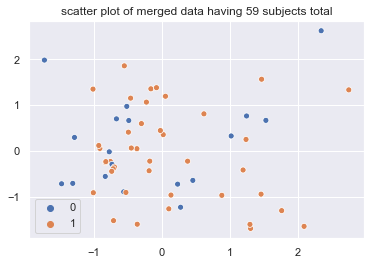

In [10]:
sns.scatterplot(X_merg[:,0], X_merg[:,2], hue=y_merg)
plt.title('scatter plot of merged data having 59 subjects total')
plt.show()

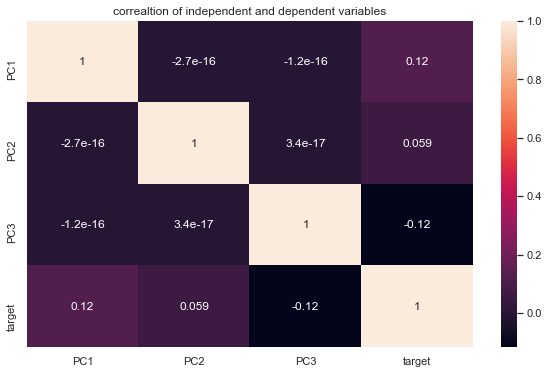

In [11]:
df_p = pd.DataFrame(data=X_merg, columns=['PC1', 'PC2', 'PC3'])#, 'PC4', 'PC5', 'PC6', 'PC7'])
df_p['target'] = y_merg
plt.figure(figsize=(10,6))
plt.title('correaltion of independent and dependent variables')
sns.heatmap(df_p.corr(), annot=True)
plt.show()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_merg, y_merg, test_size=0.10, random_state=42)

In [32]:
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model coefficients: [[ 0.2514943   0.13627855 -0.28344713]]
confusion matrix:
 [[0 2]
 [0 4]] 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      1.00      0.80         4

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6



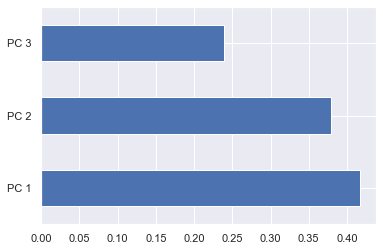

In [33]:
predicted = model.predict(X_test)
print('model coefficients: {}' .format(model.coef_))
print(('confusion matrix:\n {} ') .format(confusion_matrix(y_test, predicted)))
print(classification_report(y_test, predicted))
feat_importances = pd.Series((model.coef_[0]+1)/3, index=['PC 1', 'PC 2', 'PC 3'])
feat_importances.nlargest(4).plot(kind='barh')

In [15]:
predicted = model.predict(X_train)
print(('confusion matrix:\n {} ') .format(confusion_matrix(y_train, predicted)))
print(classification_report(y_train, predicted))

confusion matrix:
 [[ 1 15]
 [ 0 37]] 
              precision    recall  f1-score   support

           0       1.00      0.06      0.12        16
           1       0.71      1.00      0.83        37

    accuracy                           0.72        53
   macro avg       0.86      0.53      0.47        53
weighted avg       0.80      0.72      0.62        53



In [16]:
k_fold = KFold(n_splits=10, random_state=1)
accuracy_array = []

LR = LogisticRegression(random_state=0)
for k, (train, test) in enumerate(k_fold.split(X_merg, y_merg)):
    LR.fit(X_merg[train], y_merg[train])
    accuracy_array.append(LR.score(X_merg[test], y_merg[test]))
    print('cross validation fold {} result: {}' .format(k, LR.score(X_merg[test], y_merg[test])))
    
print('\naverage accuracy of 10-fold: {}' .format(np.mean(accuracy_array)))

cross validation fold 0 result: 0.5
cross validation fold 1 result: 0.5
cross validation fold 2 result: 1.0
cross validation fold 3 result: 0.8333333333333334
cross validation fold 4 result: 0.5
cross validation fold 5 result: 0.6666666666666666
cross validation fold 6 result: 0.8333333333333334
cross validation fold 7 result: 0.5
cross validation fold 8 result: 0.6666666666666666
cross validation fold 9 result: 1.0

average accuracy of 10-fold: 0.7000000000000001


C:\Users\Shahzeb\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [17]:
accuracy_average = []
loo = LeaveOneOut()
loo.get_n_splits(X_merg)
i = 0

for train, test in loo.split(X_merg):
    
    LR.fit(X_merg[train], y_merg[train])
    accuracy_average.append(LR.score(X_merg[test], y_merg[test]))
    #print('cross validation fold {} result: {}' .format(i, LR.score(X_merg[test], y_merg[test])))
    i += 1
    
print('\naverage accuracy of one leave out CV: {}' .format(np.mean(accuracy_average)))

warnings.filterwarnings('ignore', category=UserWarning, append=True)


average accuracy of one leave out CV: 0.6610169491525424


[0.27493495 0.35612954 0.36893551]


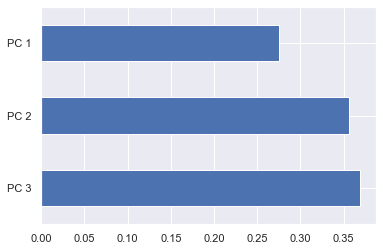

In [30]:
# https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
# https://scikit-learn.org/stable/modules/feature_selection.html

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=['PC 1', 'PC 2', 'PC 3'])#, 'PC 4'])
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

In [26]:
# https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html
# analysing the features contibution
loadings = pd.DataFrame(pca.components_.T , columns=['PC1', 'PC2', 'PC3'], index=df_feat.columns)
loadings.head(1)

PC1       PC2       PC3
alpha_std  0.123073  0.059366  0.008213

In [27]:
pd.set_option('display.max_rows', loadings.shape[0]+1)
loadings.sort_values(by='PC1', ascending=False)

PC1       PC2       PC3
alpha_energy          0.127211  0.044779 -0.015010
alpha_variance        0.127211  0.044779 -0.015010
alpha_std             0.126274  0.050692 -0.008716
alpha_variance        0.125770  0.038368  0.031403
alpha_energy          0.125770  0.038368  0.031403
alpha_std             0.125102  0.047046  0.026457
alpha_std             0.123174  0.040360  0.044973
alpha_std             0.123073  0.059366  0.008213
alpha_variance        0.122232  0.054454  0.016158
alpha_energy          0.122232  0.054454  0.016158
alpha_std             0.119124  0.031439  0.057646
theta_energy          0.118139  0.014414 -0.065839
theta_variance        0.118139  0.014414 -0.065839
theta_std             0.116911  0.019743 -0.065979
alpha_energy          0.116871  0.018032  0.065173
alpha_variance        0.116871  0.018032  0.065173
alpha_variance        0.115739  0.025285  0.066159
alpha_energy          0.115739  0.025285  0.066159
delta_std             0.113002 -0.045668 -0.053924
theta_std             0.109062  0.025512 -0.093265
delta_energy          0.109050 -0.071129 -0.054759
delta_variance        0.109049 -0.071130 -0.054761
theta_std             0.108384  0.009674 -0.089014
delta_energy          0.108162 -0.077204 -0.044430
delta_variance        0.108161 -0.077206 -0.044430
delta_std             0.108078 -0.078785 -0.021756
theta_std             0.107479  0.033646 -0.095712
delta_std             0.107294 -0.068227 -0.045443
delta_std             0.106687 -0.076008 -0.051773
delta_std             0.105667 -0.076563 -0.058517
theta_energy          0.104485  0.021747 -0.095969
theta_variance        0.104485  0.021747 -0.095969
theta_energy          0.104456  0.008603 -0.089816
theta_variance        0.104456  0.008603 -0.089816
delta_energy          0.104382 -0.037632 -0.034335
delta_variance        0.104380 -0.037633 -0.034338
theta_energy          0.103787  0.029055 -0.099390
theta_variance        0.103787  0.029055 -0.099390
theta_std             0.100200  0.023873 -0.088761
theta_std             0.099453  0.043043 -0.105787
alpha_std             0.098393  0.030574  0.083294
theta_energy          0.098037  0.038346 -0.105517
theta_variance        0.098037  0.038346 -0.105517
delta_energy          0.095137 -0.083064  0.024265
delta_variance        0.095136 -0.083065  0.024265
delta_power           0.090704 -0.004588  0.065921
std                   0.090071 -0.032031  0.049621
delta_energy          0.089313 -0.059145 -0.018631
delta_variance        0.089311 -0.059148 -0.018630
delta_power           0.088924 -0.000078  0.055854
alpha_energy          0.087627  0.017139  0.087140
alpha_variance        0.087627  0.017139  0.087140
delta_std             0.087496 -0.073086 -0.034848
delta_power           0.087027  0.004046  0.040422
theta_energy          0.086090  0.010511 -0.067403
theta_variance        0.086090  0.010511 -0.067403
theta_power           0.083448  0.051344  0.020096
delta_power           0.082401 -0.010906  0.082147
theta_power           0.082326  0.051874  0.022948
theta_power           0.080909  0.036137  0.048640
delta_power           0.080784  0.010256  0.029501
delta_power           0.080427 -0.001672  0.045087
theta_power           0.079939  0.056524  0.021038
theta_power           0.079499  0.055400  0.013297
alpha_power           0.075831  0.030658  0.078187
alpha_power           0.075794  0.046722  0.055699
alpha_power           0.074784  0.037175  0.069500
alpha_power           0.074382  0.046254  0.062105
alpha_power           0.073667  0.025171  0.080298
theta_power           0.070391  0.064898  0.007770
alpha_power           0.069099  0.041291  0.078798
theta_skewness        0.068975 -0.041947  0.055912
theta_skewness        0.067882 -0.031637  0.023173
theta_skewness        0.053782  0.008002  0.029196
variance              0.053634 -0.070475  0.075141
theta_entropy         0.051327  0.019455  0.144767
theta_entropy         0.051078  0.011236  0.140953
theta_complexity      0.049772 -0.093755  0.10925

In [28]:
loadings.sort_values(by='PC2', ascending=False)

PC1       PC2       PC3
delta_entropy        -0.019947  0.151531  0.036441
delta_entropy         0.003014  0.149316  0.022097
delta_entropy        -0.031457  0.147966  0.030889
delta_entropy        -0.007455  0.147360  0.050023
delta_entropy        -0.015818  0.144657  0.036146
delta_entropy        -0.032537  0.137392  0.056697
theta_relative_power -0.028096  0.129921 -0.071398
theta_relative_power -0.011596  0.129659 -0.077231
theta_relative_power -0.023795  0.129292 -0.086144
delta_mobility        0.009864  0.127557  0.036289
alpha_relative_power  0.035323  0.124499  0.094332
delta_mobility       -0.005109  0.122646  0.015676
alpha_relative_power  0.029779  0.121764  0.106383
theta_mobility       -0.000251  0.118901 -0.038115
delta_mobility        0.007934  0.118327  0.055953
theta_mobility       -0.008241  0.117743 -0.017122
alpha_relative_power  0.021968  0.117336  0.109867
theta_relative_power -0.031703  0.116243 -0.084631
delta_mobility        0.006052  0.115091  0.034644
theta_mobility        0.008999  0.113510 -0.032678
delta_mobility        0.036720  0.110412  0.009768
theta_mobility       -0.022548  0.108162 -0.030068
entropy              -0.008436  0.106347  0.047617
alpha_relative_power  0.013485  0.104975  0.128063
alpha_relative_power  0.030394  0.104201  0.115661
delta_skewness       -0.054603  0.103885 -0.022601
mobility             -0.027263  0.103728  0.037670
theta_mobility        0.000904  0.103466 -0.021672
alpha_skewness        0.009634  0.092223  0.017854
delta_skewness        0.006051  0.086362  0.036732
delta_mobility       -0.017834  0.086281  0.093662
delta_skewness       -0.065422  0.084622 -0.036696
theta_relative_power -0.027199  0.084259 -0.043158
theta_relative_power -0.035859  0.083640 -0.085798
energy               -0.009964  0.081106  0.000530
power                -0.009964  0.081106  0.000530
variance             -0.009955  0.081086  0.000524
alpha_relative_power -0.015975  0.076560  0.131168
theta_mobility       -0.021065  0.068039  0.002490
std                  -0.001936  0.065552  0.009355
theta_power           0.070391  0.064898  0.007770
delta_skewness       -0.047146  0.059809 -0.054316
alpha_std             0.123073  0.059366  0.008213
theta_entropy         0.013496  0.057197  0.137472
theta_power           0.079939  0.056524  0.021038
theta_power           0.079499  0.055400  0.013297
alpha_energy          0.122232  0.054454  0.016158
alpha_variance        0.122232  0.054454  0.016158
theta_power           0.082326  0.051874  0.022948
theta_power           0.083448  0.051344  0.020096
alpha_std             0.126274  0.050692 -0.008716
alpha_std             0.125102  0.047046  0.026457
alpha_power           0.075794  0.046722  0.055699
alpha_power           0.074382  0.046254  0.062105
alpha_energy          0.127211  0.044779 -0.015010
alpha_variance        0.127211  0.044779 -0.015010
theta_std             0.099453  0.043043 -0.105787
alpha_power           0.069099  0.041291  0.078798
skewness             -0.034794  0.041060  0.037362
theta_entropy        -0.014727  0.040638  0.095529
delta_skewness        0.003640  0.040537 -0.026548
alpha_std             0.123174  0.040360  0.044973
alpha_energy          0.125770  0.038368  0.031403
alpha_variance        0.125770  0.038368  0.031403
theta_energy          0.098037  0.038346 -0.105517
theta_variance        0.098037  0.038346 -0.105517
alpha_power           0.074784  0.037175  0.069500
theta_power           0.080909  0.036137  0.048640
skewness             -0.012721  0.035675 -0.020222
alpha_entropy        -0.117680  0.035194 -0.003844
theta_std             0.107479  0.033646 -0.095712
alpha_std             0.119124  0.031439  0.057646
alpha_power           0.075831  0.030658  0.078187
alpha_std             0.098393  0.030574  0.083294
theta_energy          0.103787  0.029055 -0.099390
theta_variance        0.103787  0.029055 -0.099390
alpha_complexity     -0.109501  0.028432 -0.077369
alpha_entropy        -0.077804  0.027871  0.01478

In [29]:
loadings.sort_values(by='PC3', ascending=False)

PC1       PC2       PC3
theta_entropy         0.051327  0.019455  0.144767
theta_entropy         0.038178  0.018401  0.144440
theta_entropy         0.034586  0.015607  0.142524
theta_entropy         0.051078  0.011236  0.140953
theta_entropy         0.013496  0.057197  0.137472
alpha_mobility       -0.034813 -0.029644  0.132449
alpha_relative_power -0.015975  0.076560  0.131168
alpha_mobility       -0.049171 -0.031441  0.129954
alpha_relative_power  0.013485  0.104975  0.128063
delta_Kurtosis       -0.004465 -0.057342  0.127147
theta_complexity      0.043491 -0.068640  0.125767
alpha_mobility       -0.063557 -0.039348  0.121391
theta_Kurtosis       -0.011068 -0.072242  0.118460
alpha_mobility       -0.053551 -0.038283  0.116794
alpha_relative_power  0.030394  0.104201  0.115661
alpha_mobility       -0.042840 -0.022321  0.115131
theta_complexity      0.038606 -0.080307  0.112353
delta_Kurtosis       -0.009856 -0.049191  0.112205
theta_complexity      0.022199 -0.101866  0.111769
delta_Kurtosis       -0.023475 -0.062864  0.110255
alpha_relative_power  0.021968  0.117336  0.109867
theta_complexity      0.049772 -0.093755  0.109253
alpha_mobility       -0.050703 -0.036189  0.109023
alpha_relative_power  0.029779  0.121764  0.106383
theta_skewness        0.042560 -0.031506  0.105748
theta_Kurtosis       -0.010034 -0.073547  0.104995
theta_complexity      0.044449 -0.099739  0.104393
delta_Kurtosis       -0.039374 -0.066934  0.099669
delta_Kurtosis       -0.037819 -0.045158  0.099453
theta_entropy        -0.014727  0.040638  0.095529
theta_complexity      0.037860 -0.033868  0.094906
alpha_relative_power  0.035323  0.124499  0.094332
delta_mobility       -0.017834  0.086281  0.093662
theta_Kurtosis       -0.030985 -0.071177  0.092473
theta_Kurtosis       -0.010575 -0.052130  0.089568
alpha_energy          0.087627  0.017139  0.087140
alpha_variance        0.087627  0.017139  0.087140
alpha_Kurtosis       -0.035721 -0.051712  0.086788
alpha_std             0.098393  0.030574  0.083294
delta_power           0.082401 -0.010906  0.082147
alpha_power           0.073667  0.025171  0.080298
alpha_power           0.069099  0.041291  0.078798
theta_Kurtosis       -0.034686 -0.065808  0.078305
alpha_power           0.075831  0.030658  0.078187
complexity            0.046845 -0.003666  0.076549
variance              0.053634 -0.070475  0.075141
power                 0.048565 -0.071053  0.074034
energy                0.048565 -0.071053  0.074034
delta_Kurtosis       -0.006685 -0.024682  0.069609
alpha_power           0.074784  0.037175  0.069500
alpha_variance        0.115739  0.025285  0.066159
alpha_energy          0.115739  0.025285  0.066159
alpha_Kurtosis       -0.053498 -0.043983  0.065987
delta_power           0.090704 -0.004588  0.065921
alpha_skewness        0.013829  0.027381  0.065177
alpha_variance        0.116871  0.018032  0.065173
alpha_energy          0.116871  0.018032  0.065173
alpha_power           0.074382  0.046254  0.062105
alpha_std             0.119124  0.031439  0.057646
delta_entropy        -0.032537  0.137392  0.056697
alpha_entropy        -0.105416  0.003006  0.056658
delta_mobility        0.007934  0.118327  0.055953
theta_skewness        0.068975 -0.041947  0.055912
delta_power           0.088924 -0.000078  0.055854
alpha_power           0.075794  0.046722  0.055699
delta_entropy        -0.007455  0.147360  0.050023
std                   0.090071 -0.032031  0.049621
theta_power           0.080909  0.036137  0.048640
entropy              -0.008436  0.106347  0.047617
theta_Kurtosis       -0.000592 -0.052642  0.047004
delta_power           0.080427 -0.001672  0.045087
alpha_std             0.123174  0.040360  0.044973
Kurtosis             -0.036245 -0.056585  0.043367
delta_power           0.087027  0.004046  0.040422
mobility             -0.027263  0.103728  0.037670
skewness             -0.034794  0.041060  0.037362
delta_skewness        0.006051  0.086362  0.036732
delta_entropy        -0.019947  0.151531  0.03644

In [28]:
loadings.sort_values(by='PC4', ascending=False)

PC1       PC2       PC3       PC4       PC5
theta_power           0.080909  0.036137  0.048640  0.161627  0.038896
alpha_power           0.075794  0.046722  0.055699  0.161016  0.030336
theta_power           0.070391  0.064898  0.007770  0.160464  0.015857
theta_power           0.079939  0.056524  0.021038  0.160294  0.035012
alpha_power           0.074382  0.046254  0.062105  0.159451  0.026924
alpha_power           0.069099  0.041291  0.078798  0.158476  0.020506
theta_power           0.082326  0.051874  0.022948  0.157775  0.035350
theta_power           0.083448  0.051344  0.020096  0.156626  0.033147
alpha_power           0.074784  0.037175  0.069500  0.155975  0.033286
alpha_power           0.073667  0.025171  0.080298  0.149287  0.037801
alpha_power           0.075831  0.030658  0.078187  0.149074  0.038897
theta_power           0.079499  0.055400  0.013297  0.144838  0.047005
delta_power           0.087027  0.004046  0.040422  0.144171  0.005551
delta_power           0.088924 -0.000078  0.055854  0.143702  0.021557
delta_complexity     -0.025753 -0.091752 -0.055416  0.139103 -0.015776
delta_complexity      0.003019 -0.091456 -0.048922  0.137062 -0.040625
alpha_complexity     -0.065098  0.006785 -0.069091  0.129492 -0.003161
delta_complexity     -0.013166 -0.097054 -0.034048  0.128538 -0.049222
delta_power           0.080784  0.010256  0.029501  0.127270 -0.013027
delta_power           0.090704 -0.004588  0.065921  0.118118  0.052800
delta_power           0.082401 -0.010906  0.082147  0.117975  0.052326
variance             -0.009955  0.081086  0.000524  0.115793  0.023458
energy               -0.009964  0.081106  0.000530  0.115779  0.023441
power                -0.009964  0.081106  0.000530  0.115779  0.023441
std                  -0.001936  0.065552  0.009355  0.114462  0.049959
alpha_entropy        -0.077804  0.027871  0.014789  0.109191  0.010426
delta_complexity     -0.052747 -0.102658 -0.039066  0.109049 -0.032581
delta_power           0.080427 -0.001672  0.045087  0.108784  0.048007
delta_Kurtosis       -0.009856 -0.049191  0.112205  0.100008  0.047508
delta_Kurtosis       -0.006685 -0.024682  0.069609  0.098146 -0.089048
theta_mobility        0.008999  0.113510 -0.032678  0.096666 -0.140351
delta_complexity     -0.002350 -0.112735 -0.027534  0.095009 -0.096402
delta_complexity     -0.060806 -0.097499 -0.012425  0.093581 -0.055869
theta_relative_power -0.027199  0.084259 -0.043158  0.091151  0.153882
theta_mobility       -0.000251  0.118901 -0.038115  0.090286 -0.120436
theta_skewness        0.042560 -0.031506  0.105748  0.088688  0.101859
theta_mobility        0.000904  0.103466 -0.021672  0.087721 -0.149741
entropy               0.049307 -0.043378 -0.077882  0.082219  0.000669
delta_Kurtosis       -0.023475 -0.062864  0.110255  0.079656  0.046368
alpha_skewness       -0.032403 -0.006139 -0.019341  0.078591 -0.001160
theta_skewness        0.053782  0.008002  0.029196  0.078457  0.014532
theta_mobility       -0.008241  0.117743 -0.017122  0.077557 -0.124205
mobility             -0.028854 -0.019865 -0.082104  0.076798  0.106807
complexity            0.020043 -0.099957 -0.051002  0.076233 -0.067878
delta_Kurtosis       -0.037819 -0.045158  0.099453  0.067576  0.008488
delta_skewness        0.036273 -0.015565 -0.063353  0.067382 -0.003140
alpha_skewness       -0.040224  0.001469 -0.001127  0.066413 -0.033868
theta_skewness        0.067882 -0.031637  0.023173  0.065615  0.070755
delta_Kurtosis       -0.004465 -0.057342  0.127147  0.062156  0.035377
std                   0.090071 -0.032031  0.049621  0.061989 -0.050238
theta_skewness        0.068975 -0.041947  0.055912  0.060565  0.099068
theta_relative_power -0.035859  0.083640 -0.085798  0.058863  0.112765
theta_mobility       -0.022548  0.108162 -0.030068  0.058315 -0.129413
energy                0.048565 -0.071053  0.074034  0.056899  0.028814
power                 0.048565 -0.071053  0.074034  0.056899  0.028814
alpha_skewness       -0.054701 -0.019874 -0.034044 

In [31]:
loadings.sort_values(by='PC5', ascending=False)

PC1       PC2       PC3       PC4       PC5
alpha_Kurtosis       -0.017486 -0.023636  0.003599 -0.003461  0.202724
alpha_Kurtosis       -0.080962 -0.029356  0.034096 -0.005951  0.179631
alpha_Kurtosis       -0.026420 -0.031774  0.004813 -0.039118  0.174797
alpha_Kurtosis       -0.053498 -0.043983  0.065987 -0.022886  0.165828
theta_relative_power -0.027199  0.084259 -0.043158  0.091151  0.153882
Kurtosis             -0.036245 -0.056585  0.043367  0.000920  0.148590
delta_mobility       -0.005109  0.122646  0.015676 -0.067658  0.145591
alpha_Kurtosis       -0.038979 -0.050774  0.032952 -0.015233  0.144363
alpha_Kurtosis       -0.035721 -0.051712  0.086788  0.035566  0.141488
alpha_mobility       -0.050703 -0.036189  0.109023 -0.033921  0.135567
alpha_mobility       -0.042840 -0.022321  0.115131 -0.028188  0.125501
theta_variance        0.086090  0.010511 -0.067403 -0.061283  0.113995
theta_energy          0.086090  0.010511 -0.067403 -0.061283  0.113995
theta_relative_power -0.035859  0.083640 -0.085798  0.058863  0.112765
delta_mobility       -0.017834  0.086281  0.093662 -0.095695  0.110109
delta_mobility        0.036720  0.110412  0.009768 -0.096020  0.108672
mobility             -0.028854 -0.019865 -0.082104  0.076798  0.106807
alpha_mobility       -0.063557 -0.039348  0.121391 -0.028003  0.105105
theta_skewness        0.042560 -0.031506  0.105748  0.088688  0.101859
delta_variance        0.048081 -0.048392  0.009392 -0.057882  0.100608
delta_energy          0.048080 -0.048390  0.009394 -0.057883  0.100608
alpha_mobility       -0.049171 -0.031441  0.129954 -0.038978  0.100401
delta_mobility        0.006052  0.115091  0.034644 -0.110574  0.100049
theta_relative_power -0.011596  0.129659 -0.077231  0.004196  0.099196
theta_skewness        0.068975 -0.041947  0.055912  0.060565  0.099068
theta_std             0.100200  0.023873 -0.088761 -0.041505  0.080001
theta_relative_power -0.028096  0.129921 -0.071398  0.005009  0.077160
theta_relative_power -0.023795  0.129292 -0.086144  0.022748  0.076114
theta_relative_power -0.031703  0.116243 -0.084631  0.050942  0.074182
mobility             -0.027263  0.103728  0.037670 -0.061676  0.071729
delta_mobility        0.009864  0.127557  0.036289 -0.094689  0.071708
theta_skewness        0.067882 -0.031637  0.023173  0.065615  0.070755
alpha_mobility       -0.034813 -0.029644  0.132449 -0.015951  0.068373
delta_entropy        -0.031457  0.147966  0.030889 -0.009337  0.068008
delta_entropy         0.003014  0.149316  0.022097 -0.055444  0.066974
delta_std             0.087496 -0.073086 -0.034848 -0.051798  0.065840
alpha_entropy        -0.112306  0.007331  0.005527  0.047109  0.065120
theta_complexity      0.038606 -0.080307  0.112353 -0.085138  0.063415
entropy              -0.008436  0.106347  0.047617 -0.076446  0.058654
theta_variance        0.104485  0.021747 -0.095969 -0.038319  0.055537
theta_energy          0.104485  0.021747 -0.095969 -0.038319  0.055536
theta_Kurtosis       -0.010575 -0.052130  0.089568 -0.019165  0.053527
theta_complexity      0.043491 -0.068640  0.125767 -0.053584  0.053084
delta_power           0.090704 -0.004588  0.065921  0.118118  0.052800
delta_power           0.082401 -0.010906  0.082147  0.117975  0.052326
theta_variance        0.103787  0.029055 -0.099390 -0.029275  0.050646
theta_energy          0.103787  0.029055 -0.099390 -0.029275  0.050646
std                  -0.001936  0.065552  0.009355  0.114462  0.049959
delta_power           0.080427 -0.001672  0.045087  0.108784  0.048007
delta_mobility        0.007934  0.118327  0.055953 -0.109068  0.047948
delta_Kurtosis       -0.009856 -0.049191  0.112205  0.100008  0.047508
theta_power           0.079499  0.055400  0.013297  0.144838  0.047005
delta_Kurtosis       -0.023475 -0.062864  0.110255  0.079656  0.046368
alpha_mobility       -0.053551 -0.038283  0.116794  0.030757  0.045503
theta_complexity      0.022199 -0.101866  0.111769 -0.074993  0.043743
theta_variance        0.118139  0.014414 -0.065839 

In [ ]:
#loadings.sort_values(by='PC5')

In [ ]:
group = loadings[['PC2', 'PC4']].groupby(by = df_feat.columns).mean()
group

In [ ]:
# checking accuracy of trained model with 32 subjects (another dataset) features

X_l = pd.read_csv('large_dataset_predictors/PSG8_5PC.csv')
y_l = pd.read_csv('large_dataset_predictors/PSG8_3_Clustering.csv')[['label']]

In [ ]:
# checking accuracy of trained model with 32 subjects (another dataset) features

predicted = model.predict(X_l)
print(classification_report(y_l, predicted))
print('ROC results: {}'.format(roc_auc_score(y_l, predicted)))

Applying support vector machine estimator

In [35]:
# https://towardsdatascience.com/svm-hyper-parameter-tuning-using-gridsearchcv-49c0bc55ce29

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001], 'kernel': ['rbf', 'poly', 'sigmoid']}
              
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(), param_grid, refit=True)
grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [36]:
print(grid.best_estimator_)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [37]:
svm = SVC(C=100, gamma=1, kernel='rbf', random_state=0)
svm.fit(X_train, y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [38]:
predictions = svm.predict(X_train)
print(classification_report(y_train, predictions))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        37

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53



In [93]:
k_fold = KFold(n_splits=10, random_state=1)
accuracy_array = []

SVM = SVC(C=100, gamma=1, kernel='rbf', random_state=0)
for k, (train, test) in enumerate(k_fold.split(X_merg, y_merg)):
    SVM.fit(X_merg[train], y_merg[train])
    accuracy_array.append(SVM.score(X_merg[test], y_merg[test]))
    print('cross validation fold {} result: {}' .format(k, SVM.score(X_merg[test], y_merg[test])))
    
print('\naverage accuracy of 10-fold: {}' .format(np.mean(accuracy_array)))

cross validation fold 0 result: 0.5
cross validation fold 1 result: 0.5
cross validation fold 2 result: 1.0
cross validation fold 3 result: 0.8333333333333334
cross validation fold 4 result: 0.5
cross validation fold 5 result: 0.6666666666666666
cross validation fold 6 result: 0.8333333333333334
cross validation fold 7 result: 0.5
cross validation fold 8 result: 0.6666666666666666
cross validation fold 9 result: 0.8

average accuracy of 10-fold: 0.68


C:\Users\Shahzeb\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [94]:
accuracy_array = []
loo = LeaveOneOut()
loo.get_n_splits(X_merg)
i = 0

SVM = SVC(C=100, gamma=1, kernel='rbf', random_state=0)
for train, test in loo.split(X_merg):
    SVM.fit(X_merg[train], y_merg[train])
    accuracy_array.append(SVM.score(X_merg[test], y_merg[test]))
    #print('cross validation fold {} result: {}' .format(i, SVM.score(X_merg[test], y_merg[test])))
    i += 1
print('\naverage accuracy of one leave out CV: {}' .format(np.mean(accuracy_array)))

warnings.filterwarnings('ignore', category=UserWarning, append=True)


average accuracy of one leave out CV: 0.7796610169491526


In [38]:
# checking accuracy of trained model with 32 subjects (another dataset) features

predicted = svm.predict(X_l)
print(classification_report(y_l, predicted))
print('ROC results: {}'.format(roc_auc_score(y_l, predicted)))

              precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       0.85      1.00      0.92        23

    accuracy                           0.88        32
   macro avg       0.93      0.78      0.82        32
weighted avg       0.89      0.88      0.86        32

ROC results: 0.7777777777777778
